In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2 

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.dknn_attack_v2 import DKNNAttackV2
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNNL2
from lib.utils import *
from lib.lip_model import *

Loading faiss with AVX2 support.


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [6]:
model_name = 'mnist_basic.h5'
net = BasicModel()

# model_name = 'train_mnist_nca_exp2.h5'
# model_name = 'adv_mnist_nca_exp42_epoch119.h5'
# model_name = 'adv_mnist_nca_exp19.h5'
# net = NCAModel(output_dim=100, init_it=1, train_data=(x_train, y_train))
# net = NCAModelV3(output_dim=100, init_it=1, train_data=(x_train, y_train))

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# # net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=128)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'lip_mnist_exp%d.h5' % exp_id
# net = LipschitzModel()

# model_name = 'dist_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# net = NeighborModel(num_classes=10, init_it=init_it, train_it=train_it)

# model_name = 'mnist_at.h5'
# model_name = 'adv_mnist_exp6.h5'
# basic_net = BasicModel()
# # basic_net = BasicModelV2()
# config = {'epsilon': 0.3,
#           'num_steps': 40,
#           'step_size': 0.01,
#           'random_start': True,
#           'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

# model_name = 'lipae_mnist_exp%d.h5' % exp_id
# init_it = 1
# train_it = False
# latent_dim = 128
# alpha = 1e2
# net = NCA_AE(latent_dim=latent_dim, init_it=init_it,
#              train_it=train_it, alpha=alpha)

# orig_model = 'adv_mnist_exp2.h5'
# model_name = 'tune%d_%s' % (exp_id, orig_model)
# net = BasicModel()
# from tune_mnist import Identity
# net.fc = Identity()

# model_name = 'rot_mnist_exp%d.h5' % exp_id
# net = BasicModel(num_classes=4)

# model_name = 'adv_rot_mnist_exp%d.h5' % exp_id
# basic_net = BasicModel(num_classes=4)
# config = {'num_steps': 20,
#           'step_size': 0.05,
#           'random_start': True,
#           'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

# model_name = 'ae_mnist_exp%d.h5' % exp_id
# net = Autoencoder((1, 28, 28), 128)

# model_name = 'adv_mnist_ae_exp%d.h5' % exp_id
# basic_net = Autoencoder((1, 28, 28), latent_dim=128)
# config = {'num_steps': 40,
#               'step_size': 0.1,
#               'random_start': True,
#               'loss_func': 'xent'}
# net = PGDL2Model(basic_net, config)

In [7]:
# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models/mnist/')
# save_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [8]:
with torch.no_grad():
    y_pred = net(x_test.to(device))
    ind = np.where(y_pred.argmax(1).cpu() == y_test)[0]
    print('acc: ', len(ind) / y_test.size(0))

acc:  0.9878


In [12]:
net_knn = KNNModel()
layers = ['identity']
dknn = DKNNL2(net_knn, x_train, y_train, 
              x_test, y_test, layers, 
              k=100, num_classes=10)

In [10]:
layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu3']
# layers = ['fc']
# layers = ['en_conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#             k=75, num_classes=10)
dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              cosine=True, k=75, num_classes=10)

In [ ]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

In [96]:
(np.take_along_axis(y_pred, y_test.unsqueeze(-1).numpy(), axis=1).flatten() == y_pred.max(1)).mean()

0.9704

In [12]:
cred = dknn.credibility(y_pred)

(array([ 958.,  959.,  956.,  785., 1190.,    0.,    0.,    0.,    0.,
        5152.]),
 array([0.00366667, 0.1033    , 0.20293333, 0.30256667, 0.4022    ,
        0.50183333, 0.60146667, 0.7011    , 0.80073333, 0.90036667,
        1.        ]),
 <a list of 10 Patch objects>)

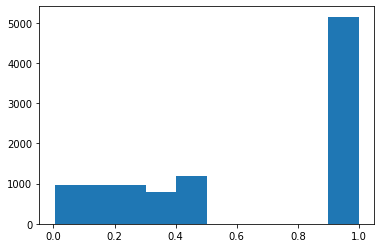

In [13]:
plt.hist(cred)

In [21]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

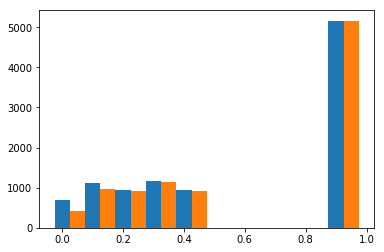

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [15]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.52764613, 0.83124478, 0.94539249, 0.98878343, 0.99498495,
              nan,        nan,        nan,        nan, 0.99922103])

---

## DkNN Attack

In [105]:
# Attack for L2 DkNN

attack = DKNNAttackV2()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = int(np.ceil(total_num / batch_size))
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=10, binary_search_steps=10,
            max_iterations=1000, learning_rate=1e-2, guide_mode=2,
            initial_const=1e-1, abort_early=True, random_start=False)
    return x_adv

num = 100
x_adv = attack_batch(x_test[:num].cuda(), y_test[:num], 100)

    step: 0; loss: 0.869; l2dist: 0.000
    step: 100; loss: 0.866; l2dist: 0.044
    step: 200; loss: 0.867; l2dist: 0.047
binary step: 0; num successful adv: 1/100
binary step: 0; num successful adv so far: 1/100
    step: 0; loss: 8.632; l2dist: 0.000
    step: 100; loss: 8.325; l2dist: 0.472
    step: 200; loss: 8.325; l2dist: 0.472
binary step: 1; num successful adv: 7/100
binary step: 1; num successful adv so far: 7/100
    step: 0; loss: 82.638; l2dist: 0.000
    step: 100; loss: 64.817; l2dist: 2.652
    step: 200; loss: 59.685; l2dist: 2.772
    step: 300; loss: 53.118; l2dist: 3.369
    step: 400; loss: 52.504; l2dist: 3.457
    step: 500; loss: 52.339; l2dist: 3.486
    step: 600; loss: 52.294; l2dist: 3.498
    step: 700; loss: 52.278; l2dist: 3.503
    step: 800; loss: 52.273; l2dist: 3.505
binary step: 2; num successful adv: 75/100
binary step: 2; num successful adv so far: 77/100
    step: 0; loss: 249.718; l2dist: 0.000
    step: 100; loss: 207.365; l2dist: 2.538
    st

In [98]:
from lib.dknn_attack_exp import DKNNExpAttack
attack = DKNNExpAttack(dknn)

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = int(np.ceil(total_num / batch_size))
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end],
            guide_layer=layers[0], m=10, init_mode=1, 
            binary_search_steps=10, max_iterations=1000, learning_rate=1e-1,
            initial_const=1e-1, random_start=False,
            thres_steps=200, check_adv_steps=200, verbose=True,
            max_linf=None)
    return x_adv

num = 100
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100)

    step: 0; loss: 9.193; l2dist: 0.000
    step: 100; loss: 5.806; l2dist: 1.497
    step: 200; loss: 5.825; l2dist: 1.508
    step: 300; loss: 5.700; l2dist: 1.489
    step: 400; loss: 5.724; l2dist: 1.498
    step: 500; loss: 5.719; l2dist: 1.494
    step: 600; loss: 5.708; l2dist: 1.508
    step: 700; loss: 5.735; l2dist: 1.511
    step: 800; loss: 5.710; l2dist: 1.516
    step: 900; loss: 5.742; l2dist: 1.515
binary step: 0; num successful adv: 18/100
binary step: 0; num successful adv so far: 22/100
    step: 0; loss: 85.556; l2dist: 0.000
    step: 100; loss: 14.715; l2dist: 2.686
    step: 200; loss: 13.328; l2dist: 2.651
    step: 300; loss: 11.021; l2dist: 2.637
    step: 400; loss: 11.123; l2dist: 2.609
    step: 500; loss: 10.034; l2dist: 2.641
    step: 600; loss: 10.146; l2dist: 2.640
    step: 700; loss: 9.722; l2dist: 2.641
    step: 800; loss: 9.791; l2dist: 2.627
    step: 900; loss: 9.821; l2dist: 2.661
binary step: 1; num successful adv: 79/100
binary step: 1; num s

In [13]:
def attack_batch(attack, x, y, init_mode, init_mode_k, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end], 2, guide_layer=layers, m=150,
            init_mode=init_mode, init_mode_k=init_mode_k,
            binary_search_steps=10, max_iterations=1000, learning_rate=1e-1,
            initial_const=1e-1, max_linf=None, random_start=True,
            thres_steps=200, check_adv_steps=200, verbose=False)
    return x_adv

num = 100

def full_eval(dknn):
    with torch.no_grad():
        y_pred = dknn.classify(x_test)
        ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))
    
    dist_all = np.zeros(num) + 1e9
    attack = DKNNAttackV2(dknn)
    
    x_adv = attack_batch(
        attack, x_test[ind][:num].cuda(), y_test[ind][:num], 1, 1, 100)
    with torch.no_grad():
        y_pred = dknn.classify(x_adv)
        ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
        dist = (x_adv.cpu() - x_test[ind][:num]).view(
            num, -1).norm(2, 1).numpy()
    for i in range(num):
        if ind_adv[i] and (dist[i] < dist_all[i]):
            dist_all[i] = dist[i]
            
    for k in range(1, 6):
        x_adv = attack_batch(
            attack, x_test[ind][:num].cuda(), y_test[ind][:num], 2, k, 100)
        with torch.no_grad():
            y_pred = dknn.classify(x_adv)
            ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
            dist = (x_adv.cpu() - x_test[ind][:num]).view(
                num, -1).norm(2, 1).numpy()
        for i in range(num):
            if ind_adv[i] and (dist[i] < dist_all[i]):
                dist_all[i] = dist[i]
                
    adv_acc = (dist_all == 1e9).mean()
    print('adv accuracy: %.4f, mean dist: %.4f' % (
        adv_acc, dist_all[dist_all < 1e9].mean()))
    return dist_all

In [ ]:
start = time.time()
dist = full_eval(dknn)
print(time.time() - start)

0.9877


In [15]:
dist.mean()

1.753950898051262

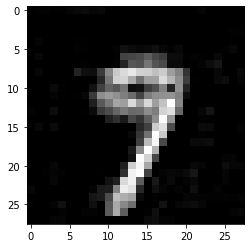

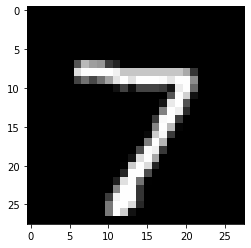

4.7507405281066895


In [24]:
i = 0
plt.imshow(x_adv[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(x_test[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')
plt.show()
print((x_adv[i].cpu() - x_test[i]).view(-1).norm().item())

In [106]:
with torch.no_grad():
    y_pred = dknn.classify(x_adv)
    ind_adv = np.where(y_pred.argmax(1) != y_test[ind][:num].numpy())[0]
    print((y_pred.argmax(1) == y_test[ind][:num].numpy()).sum() / y_pred.shape[0])

0.02


In [107]:
(x_adv.cpu() - x_test[ind][:num]).view(num, -1).norm(2, 1)[ind_adv].mean().item()

4.4058709144592285

In [28]:
logits = net.compute_logits(x_adv.cuda())
acc = (logits.argmax(1).cpu() == y_test[ind][:num]).float().mean()
print(acc)

tensor(0.7600)


(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

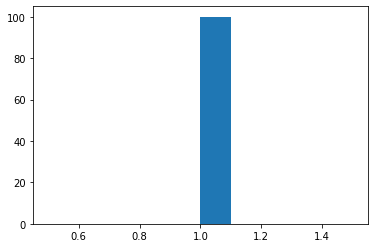

In [18]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

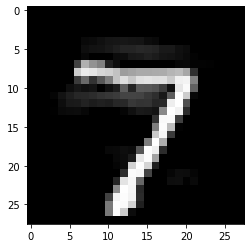

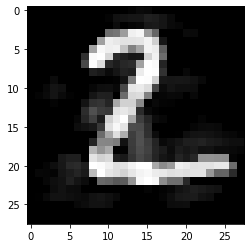

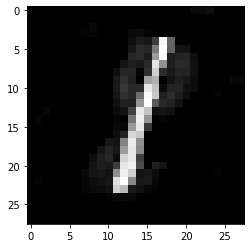

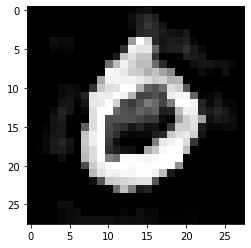

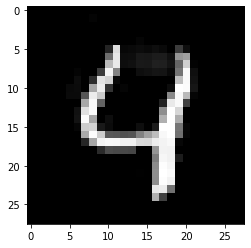

In [19]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.show()

In [15]:
attack = DKNN_PGD(dknn)

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end],
            guide_layer=layers[0], m=24, epsilon=0.01,
            max_epsilon=0.3, max_iterations=500, num_restart=1,
            rand_start=True, thres_steps=100, check_adv_steps=100,
            verbose=True)
    return x_adv

num = 100
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 100)

    step: 0; loss: 7807.614
    step: 50; loss: 1300.460
    step: 100; loss: 740.567
    step: 150; loss: 579.734
    step: 200; loss: 498.007
    step: 250; loss: 458.374
    step: 300; loss: 445.230
    step: 350; loss: 428.613
    step: 400; loss: 425.181
    step: 450; loss: 416.420
number of successful adv: 80/100


## CW L2 Attack

without DkNN

In [19]:
from lib.cwl2_attack import CWL2Attack

attack = CWL2Attack(net, x_train=x_train, y_train=y_train)

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end], targeted=False,
            init_mode=2, binary_search_steps=10, max_iterations=1000,
            confidence=0, learning_rate=1e-2, initial_const=1e1, 
            abort_early=False, rand_start_std=0.1, check_adv_steps=100)
    return x_adv

num = 100
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num].cuda(), 100)

    step: 0; loss: 13.405; l2dist: 0.000
    step: 100; loss: 10.804; l2dist: 1.309
    step: 200; loss: 10.790; l2dist: 1.320
    step: 300; loss: 10.706; l2dist: 1.327
    step: 400; loss: 10.543; l2dist: 1.378
    step: 500; loss: 10.419; l2dist: 1.434
    step: 600; loss: 10.330; l2dist: 1.472
    step: 700; loss: 10.271; l2dist: 1.492
    step: 800; loss: 10.225; l2dist: 1.507
    step: 900; loss: 10.189; l2dist: 1.519
binary step: 0; number of successful adv: 18/100
    step: 0; loss: 111.046; l2dist: 0.324
    step: 100; loss: 41.892; l2dist: 3.591
    step: 200; loss: 32.390; l2dist: 3.909
    step: 300; loss: 21.221; l2dist: 3.721
    step: 400; loss: 16.908; l2dist: 3.518
    step: 500; loss: 14.763; l2dist: 3.400
    step: 600; loss: 13.892; l2dist: 3.331
    step: 700; loss: 13.365; l2dist: 3.281
    step: 800; loss: 13.029; l2dist: 3.245
    step: 900; loss: 12.853; l2dist: 3.222
binary step: 1; number of successful adv: 97/100
    step: 0; loss: 201.791; l2dist: 0.321
   

In [20]:
y_pred = net(x_adv).argmax(1).cpu()
print((y_pred == y_test[ind][:num]).numpy().sum() / y_pred.size(0))
dist = (x_adv.cpu() - x_test[ind][:num]).view(num, -1).norm(2, 1)
print(dist.mean().item(), dist.median().item())

0.0
2.9907801151275635 3.2651774883270264


In [ ]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:10000].numpy()).sum() / len(y_pred)

(array([139.,  46.,  23.,  19.,   3.,   3.,   4.,   2.,   2.,   3.]),
 array([0.0165    , 0.08763333, 0.15876667, 0.2299    , 0.30103333,
        0.37216667, 0.4433    , 0.51443333, 0.58556667, 0.6567    ,
        0.72783333]),
 <a list of 10 Patch objects>)

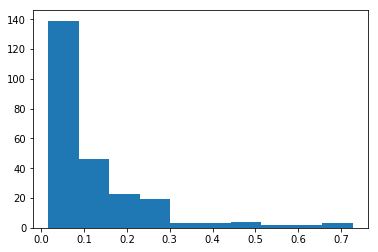

In [90]:
cred = dknn.credibility(y_pred)
suc_ind = y_pred.argmax(1) != y_test[:10000].numpy()
plt.hist(cred[suc_ind])

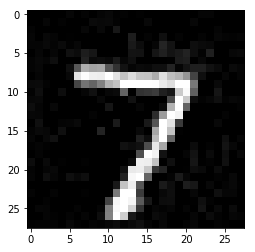

In [87]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [28]:
(x_adv.cpu() - x_test[:10000]).view(10000, -1).norm(2, 1).mean()

tensor(1.3970, grad_fn=<MeanBackward1>)

In [90]:
(x_adv.cpu() - x_test[:100]).view(100, -1).norm(2, 1).mean()

tensor(2.6813, grad_fn=<MeanBackward0>)

In [ ]:
x_adv = pickle.load(open('x_adv/x_adv_adv_cifar10_exp0.h5.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_ba_cifar10_adv2_0.2_0.001.p', 'rb'))
# x_adv = pickle.load(open('x_adv/x_adv_cifar10_resnet_exp2.h5.p', 'rb'))

In [38]:
torchvision.utils.save_image(x_adv[:15], 'mnist_cw_basic.png', nrow=15, padding=0)

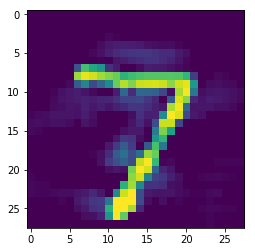

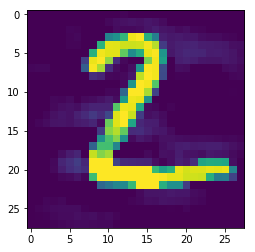

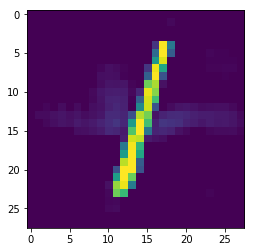

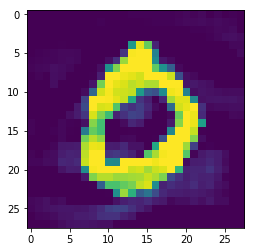

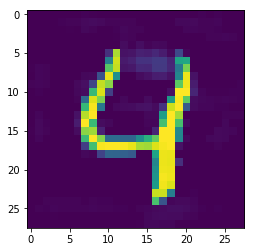

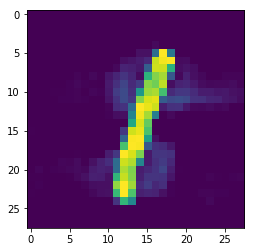

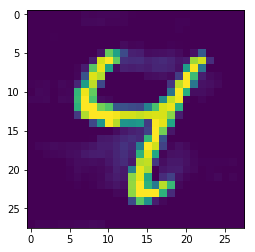

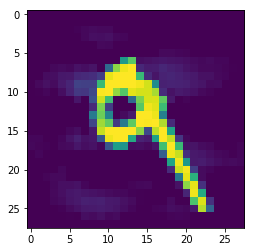

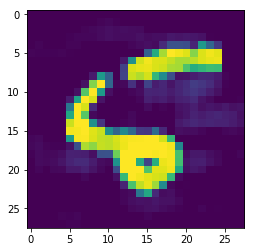

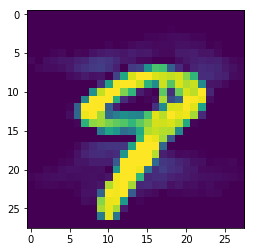

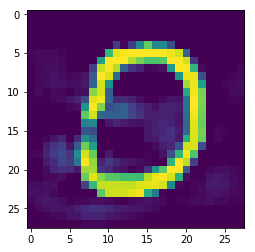

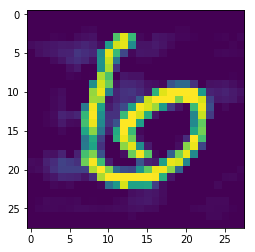

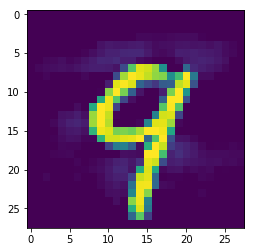

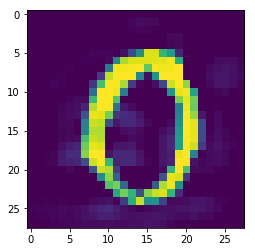

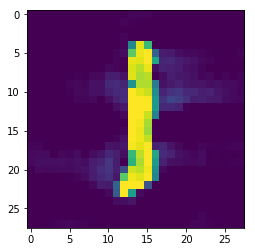

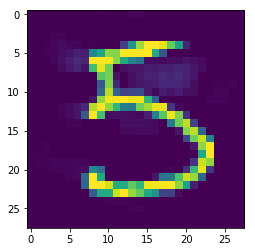

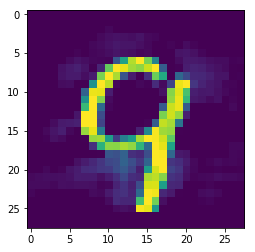

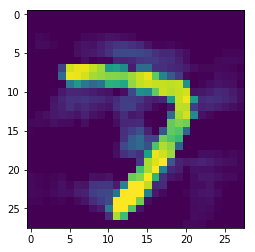

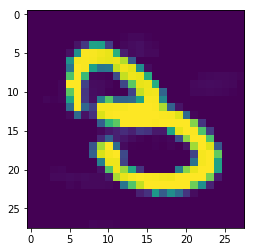

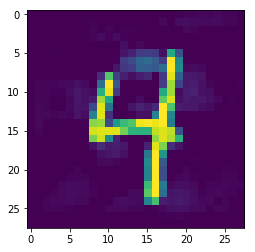

In [28]:
for i in range(20):
    plt.imshow(x_adv[i].view(28, 28).cpu().detach().numpy())
    plt.show()

In [4]:
# Subsamples dataset and reduces to two classes (1 and 7)
# Code adapted from https://github.com/yangarbiter/adversarial-nonparametrics

num_samples = 2200
num_val = 300 # can pick anything > 0, does not really get used here

from keras.datasets import mnist
(X, y), (_, _) = mnist.load_data()
np.random.seed(2019)
idx1 = np.random.choice(
    np.where(y == 1)[0], num_samples // 2, replace=False)
idx2 = np.random.choice(
    np.where(y == 7)[0], num_samples // 2, replace=False)
y[idx1] = 0
y[idx2] = 1
X = np.vstack((X[idx1], X[idx2])).astype(np.float32) / 255.
y = np.concatenate((y[idx1], y[idx2]))

idxs = np.arange(num_samples)
np.random.shuffle(idxs)
x_train_sub = torch.tensor(X[idxs[:-200]])
x_test_sub = torch.tensor(X[idxs[-200:]])
y_train_sub = torch.tensor(y[idxs[:-200]])
y_test_sub = torch.tensor(y[idxs[-200:]])

Using TensorFlow backend.


In [5]:
net_knn = KNNModel()

In [6]:
layers = ['identity']
knn = DKNNL2(net_knn, x_train_sub, y_train_sub, 
             x_test_sub, y_test_sub, layers, 
             k=1, num_classes=2)

In [7]:
with torch.no_grad():
    y_pred = knn.classify(x_test_sub)
    ind = np.where(y_pred.argmax(1) == y_test_sub.numpy())[0]
    print((y_pred.argmax(1) == y_test_sub.numpy()).sum() / y_test_sub.size(0))

0.99


In [56]:
# Attack for L2 DkNN

# attack = DKNNL2Attack()
# attack = DKNNLinfAttack()
from lib.dknn_attack_exp import DKNNExpAttack
attack = DKNNExpAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            knn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=1, binary_search_steps=15,
            max_iterations=1000, learning_rate=1e-1, guide_mode=1,
            initial_const=1e-2, abort_early=True, random_start=False)
    return x_adv

num = 200
x_adv = attack_batch(x_test_sub[:num].cuda(), y_test_sub[:num], 200)

    step: 0; loss: 0.454; l2dist: 0.000
tensor(2., device='cuda:0')
    step: 100; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 200; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 300; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 400; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 500; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 600; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 700; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 800; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
    step: 900; loss: 0.451; l2dist: 0.053
tensor(2., device='cuda:0')
tensor(2., device='cuda:0')
binary step: 0; number of successful adv: 2/200
    step: 0; loss: 4.519; l2dist: 0.000
tensor(2., device='cuda:0')
    step: 100; loss: 4.229; l2dist: 0.483
tensor(3., device='cuda:0')
    step: 200; loss: 4.229; l2dist: 0.484
tensor(3., device='cuda:0')
    step: 300; los

In [57]:
with torch.no_grad():
    y_pred = knn.classify(x_adv)
    ind = np.where(y_pred.argmax(1) == y_test_sub[:num].numpy())[0]
    print(len(ind) / x_adv.size(0))

0.0


In [57]:
# knn.get_neighbors(x_test_sub[:10], k=50)
# for idx in knn.get_neighbors(x_test_sub[:10], k=50)[0][1]:
#     print(y_train_sub[idx])

[(array([[28.832077 , 35.470264 , 36.02511  , 37.656963 , 38.208473 ,
          39.263206 , 39.646885 , 40.205055 , 41.575085 , 42.94713  ,
          43.37243  , 43.766434 , 43.78415  , 43.83922  , 44.964108 ,
          45.238632 , 45.84772  , 46.177193 , 46.570705 , 47.616356 ,
          48.474632 , 48.639538 , 49.064854 , 49.434353 , 49.726173 ,
          50.41435  , 50.961292 , 51.059917 , 51.543686 , 51.673344 ,
          51.943703 , 52.586143 , 53.02256  , 53.0845   , 53.12081  ,
          53.513096 , 53.889782 , 54.112198 , 54.16712  , 55.332428 ,
          55.341377 , 55.519882 , 55.823795 , 56.449005 , 56.474342 ,
          56.536583 , 56.65898  , 57.060356 , 57.667496 , 57.79631  ],
         [ 2.9935718,  3.2781086,  3.3305187,  3.470542 ,  3.671557 ,
           3.8215458,  4.0873203,  4.5895424,  4.626682 ,  4.6806917,
           4.728166 ,  5.0415072,  5.0883045,  5.372903 ,  5.519185 ,
           5.5237226,  5.802368 ,  6.084614 ,  6.2640057,  6.362353 ,
           6.363291

In [34]:
y_test_sub[:3]

tensor([1, 0, 0], dtype=torch.uint8)

In [37]:
y_train_sub[1931]

tensor(0, dtype=torch.uint8)

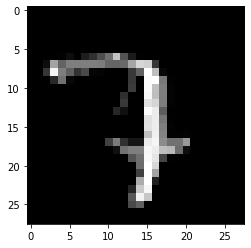

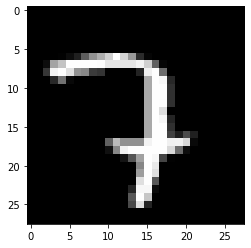

In [58]:
i = 8
plt.imshow(x_adv.cpu().detach().numpy()[i], cmap='gray')
plt.show()
plt.imshow(x_test_sub.cpu().detach().numpy()[i], cmap='gray')
plt.show()

In [58]:
(x_test_sub - x_adv.cpu()).view(num, -1).norm(2, 1).mean()

tensor(2.9113, grad_fn=<MeanBackward0>)

In [44]:
(x_test_sub - x_adv.cpu()).view(num, -1).min(1)

torch.return_types.min(
values=tensor([-0.4831, -0.4931, -0.4981, -0.4964, -0.4972, -0.4926, -0.4997, -0.4477,
        -0.4990, -0.4980, -0.4247, -0.4960, -0.4990, -0.4995, -0.4997, -0.4995,
        -0.4964, -0.4994, -0.4999, -0.4997, -0.4971, -0.4974, -0.4231, -0.4872,
        -0.4995, -0.4903, -0.5000, -0.4987, -0.4945, -0.4995, -0.4998, -0.4999,
        -0.4984, -0.4952, -0.5000, -0.4998, -0.4983, -0.4993, -0.4940, -0.4998,
        -0.4991, -0.4993, -0.4885, -0.4588, -0.4945, -0.4957, -0.4997, -0.4866,
        -0.4411, -0.4933, -0.4999, -0.4949, -0.5000, -0.4998, -0.4995, -0.3135,
        -0.4698, -0.4998, -0.5000, -0.4997, -0.4981, -0.4992, -0.4000, -0.4967,
        -0.4991, -0.4999, -0.4980, -0.4997, -0.4710, -0.4937, -0.4997, -0.4975,
        -0.4815, -0.4997, -0.4986, -0.4990, -0.4982, -0.4090, -0.4999, -0.4967,
        -0.4668, -0.4962, -0.4983, -0.4996, -0.4919, -0.4906, -0.4990, -0.4984,
        -0.4946, -0.4972, -0.4996, -0.4914, -0.4876, -0.4997, -0.4990, -0.4942,
        -

In [9]:
net.compute_logits(x_test[0:1], recompute_train_rep=True, requires_grad=False)
logits = torch.zeros((x_test.size(0), 10))

for i in range(x_test.size(0) // 100):
    logits[i * 100:(i + 1) * 100] = net.compute_logits(x_test[i * 100:(i + 1) * 100])

In [10]:
ind = np.where((logits.argmax(1) == y_test).numpy())[0]
acc = (logits.argmax(1) == y_test).float().mean()
print('Acc: %.4f' % acc)

Acc: 0.9863


In [13]:
attack = CWL2_NCA_Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=10, max_iterations=1000,
            confidence=0, learning_rate=1e-1,
            initial_const=1e2, abort_early=False)
    return x_adv

x_adv = attack_batch(x_test[ind][:100].cuda(), y_test[ind][:100].cuda(), 10)
# x_adv = attack_batch(x_test[ind][:2].cuda(), y_test[ind][:2].cuda(), 2)

    step: 0; loss: 99.682; l2dist: 0.000
    step: 100; loss: 46.878; l2dist: 1.176
    step: 200; loss: 39.503; l2dist: 1.154
    step: 300; loss: 39.618; l2dist: 1.202
    step: 400; loss: 39.449; l2dist: 1.161
    step: 500; loss: 39.968; l2dist: 1.254
    step: 600; loss: 39.540; l2dist: 1.173
    step: 700; loss: 39.788; l2dist: 1.215
    step: 800; loss: 39.506; l2dist: 1.174
    step: 900; loss: 39.391; l2dist: 1.156
binary step: 0; number of successful adv: 4/10
    step: 0; loss: 618.832; l2dist: 0.000
    step: 100; loss: 260.767; l2dist: 2.274
    step: 200; loss: 256.815; l2dist: 1.813
    step: 300; loss: 255.130; l2dist: 1.670
    step: 400; loss: 254.723; l2dist: 1.558
    step: 500; loss: 254.830; l2dist: 1.611
    step: 600; loss: 254.621; l2dist: 1.578
    step: 700; loss: 254.493; l2dist: 1.577
    step: 800; loss: 254.820; l2dist: 1.609
    step: 900; loss: 255.064; l2dist: 1.654
binary step: 1; number of successful adv: 5/10
    step: 0; loss: 5055.853; l2dist: 0.0

In [14]:
logits_adv = net.compute_logits(x_adv)
adv_ind = np.where(logits_adv.argmax(1).cpu() != y_test[ind][:100])[0]
acc = (logits_adv.argmax(1).cpu() == y_test[ind][:100]).float().numpy().mean()
print(acc)

0.06


In [15]:
(x_adv.cpu() - x_test[ind][:100]).view(100, -1).norm(2, 1)[adv_ind].mean().item()

3.8527956008911133

In [57]:
(x_adv.cpu() - x_test[ind][:100]).view(100, -1).norm(2, 1)

tensor([3.9654, 3.8659, 3.1585, 3.0521, 2.9116, 3.3393, 2.9059, 1.8409, 2.2006,
        0.7463, 3.4531, 3.1243, 0.8316, 3.7189, 3.6752, 0.7141, 7.3174, 2.4736,
        2.6379, 0.7758, 2.9101, 3.1342, 2.2701, 1.7538, 4.3092, 3.3058, 2.4876,
        3.0321, 3.2119, 2.9654, 2.8977, 3.0509, 1.7986, 3.6026, 4.0228, 2.4388,
        3.4142, 2.0723, 3.5873, 3.0175, 2.1664, 3.5316, 1.2208, 1.7057, 0.4346,
        2.6737, 2.9177, 2.0605, 4.4492, 2.4814, 2.9824, 2.9804, 0.7697, 3.8104,
        2.9644, 5.1662, 3.4106, 1.8374, 1.8860, 3.6003, 0.8830, 0.4588, 0.8025,
        3.0817, 0.4208, 2.6848, 2.7654, 2.5435, 3.8160, 6.4778, 4.8342, 3.9204,
        0.1647, 3.3441, 2.3854, 3.0777, 1.4431, 1.2292, 4.3104, 2.7652, 0.0000,
        2.8042, 3.1115, 4.7793, 3.3844, 3.4500, 4.5450, 3.6714, 3.1127, 4.6415,
        0.5048, 2.6473, 3.1263, 2.6982, 2.6311, 2.5629, 2.4965, 1.4889, 3.0107,
        4.4997], grad_fn=<NormBackward1>)

In [58]:
x_nca = x_adv.clone()

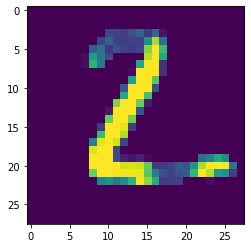

In [55]:
plt.imshow(x_adv.cpu().detach().numpy()[1].reshape(28, 28))

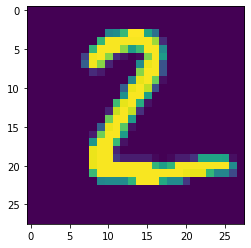

In [17]:
plt.imshow(x_test.cpu().detach().numpy()[1].reshape(28, 28))

In [16]:
INFTY = 1e20


class DKNN_PGD(object):
    """
    """

    def __init__(self, dknn):
        self.dknn = dknn
        self.device = dknn.device
        self.layers = dknn.layers
        self.guide_reps = {}
        self.thres = None
        self.coeff = None

    def __call__(self, x_orig, label, guide_layer, m, epsilon=0.1,
                 max_epsilon=0.3, max_iterations=1000, num_restart=1,
                 rand_start=True, thres_steps=100, check_adv_steps=100,
                 verbose=True):
        """
        x_orig is tensor (requires_grad=False)
        """

        # make sure we run at least once
        if num_restart < 1:
            num_restart = 1

        # if not using randomized start, no point in doing more than one start
        if not rand_start:
            num_restart = 1

        label = label.cpu().numpy()
        batch_size = x_orig.size(0)
        min_, max_ = x_orig.min(), x_orig.max()
        x_adv = x_orig.detach()
        best_num_nn = np.zeros((batch_size, ))
        
        self.coeff = torch.zeros((x_orig.size(0), m))
        self.coeff[:, :m // 2] += 1
        self.coeff[:, m // 2:] -= 1
        
        for i in range(num_restart):

            # initialize perturbation
            delta = torch.zeros_like(x_adv)
            if rand_start:
                delta.uniform_(- max_epsilon * 0.1, max_epsilon * 0.1)
            delta.requires_grad_()

            for iteration in range(max_iterations):
                x = torch.clamp(x_orig + delta, min_, max_)

                # adaptively choose threshold and guide samples every
                # <thres_steps> iterations
                with torch.no_grad():
                    if iteration % thres_steps == 0:
                        thres = self.dknn.get_neighbors(x)[0][0][:, -1]
                        self.thres = torch.tensor(thres).to(self.device).view(
                            batch_size, 1)
                        self.find_guide_samples(
                            x, label, m=m, layer=guide_layer)

                reps = self.dknn.get_activations(x, requires_grad=True)
                loss = self.loss_function(reps)
                loss.backward()
                # perform update on delta
                with torch.no_grad():
#                     import pdb; pdb.set_trace()
                    delta -= epsilon * delta.grad.detach().sign()
#                     delta -= epsilon * delta.grad.detach()
                    delta.clamp_(- max_epsilon, max_epsilon)

                if (verbose and iteration % (np.ceil(max_iterations / 10)) == 0):
                    print('    step: %d; loss: %.3f' %
                          (iteration, loss.cpu().detach().numpy()))
                
                if ((iteration + 1) % check_adv_steps == 0 or
                        iteration == max_iterations):
                    with torch.no_grad():
                        # check if x are adversarial. Only store adversarial examples
                        # if they have a larger number of wrong neighbors than orevious
                        is_adv, num_nn = self.check_adv(x, label)
                        for j in range(batch_size):
                            if is_adv[j] and num_nn[j] > best_num_nn[j]:
                                x_adv[j] = x[j]
                                best_num_nn[j] = num_nn[j]

            with torch.no_grad():
                is_adv, _ = self.check_adv(x_adv, label)
            if verbose:
                print('number of successful adv: %d/%d' % (is_adv.sum(), batch_size))

        return x_adv

    def check_adv(self, x, label):
        """Check if label of <x> predicted by <dknn> matches with <label>"""
        output = self.dknn.classify(x)
        num_nn = output.max(1)
        y_pred = output.argmax(1)
        is_adv = (y_pred != label).astype(np.float32)
#         import pdb; pdb.set_trace()
        return is_adv, num_nn

    def loss_function(self, reps):
        """Returns the loss averaged over the batch (first dimension of x) and
        L-2 norm squared of the perturbation
        """

        batch_size = reps[self.layers[0]].size(0)
        adv_loss = torch.zeros(
            (batch_size, len(self.layers)), device=self.device)
        # find squared L-2 distance between original samples and their
        # adversarial examples at each layer
        for l, layer in enumerate(self.layers):
            rep = reps[layer].view(batch_size, 1, -1)
            dist = ((rep - self.guide_reps[layer])**2).sum(2)
#             fx = self.thres - dist
#             Fx = torch.max(torch.tensor(0., device=self.device),
#                            self.coeff.to(self.device) * fx).sum(1)
#             Fx = (- self.coeff.to(self.device) * dist).sum(1)
            Fx = dist[:, 1]
            adv_loss[:, l] = Fx

        return adv_loss.mean()

    def find_guide_samples(self, x, label, m=100, layer='relu1'):
        """Find k nearest neighbors to <x> that all have the same class but not
        equal to <label>
        """
        num_classes = self.dknn.num_classes
        x_train = self.dknn.x_train
        y_train = self.dknn.y_train
        batch_size = x.size(0)
        nn = torch.zeros((m, ) + x.size()).transpose(0, 1)
        D, I = self.dknn.get_neighbors(
            x, k=x_train.size(0), layers=[layer])[0]
        y_pred = self.dknn.classify(x_train).argmax(1)
        is_correct = y_pred == y_train.numpy()

        for i, (d, ind) in enumerate(zip(D, I)):
#             mean_dist = np.zeros((num_classes, ))
#             for j in range(num_classes):
#                 mean_dist[j] = np.mean(
#                     d[np.where(y_train[ind] == j)[0]][:m // 2])
#             mean_dist[label[i]] += INFTY
#             nearest_label = mean_dist.argmin()
#             nn_ind = np.where(y_train[ind] == nearest_label)[0][:m // 2]
#             nn[i, m // 2:] = x_train[ind[nn_ind]]
#             nn_ind = np.where(y_train[ind] == label[i])[0][:m // 2]
#             nn[i, :m // 2] = x_train[ind[nn_ind]]
            # find nearest sample that is correctly classified as j
#             import pdb; pdb.set_trace()
            is_not_label = y_train.numpy() != label[i]
            idx = np.where(is_correct & is_not_label)[0]
            nn_ind = (x_train - x[i].cpu())[idx].view(
                idx.shape[0], -1).norm(2, 1).argmin()
            nn[i, 1] = x_train[idx][nn_ind]

        # initialize self.guide_reps if empty
        if not self.guide_reps:
            guide_rep = self.dknn.get_activations(
                nn[0], requires_grad=False)
            for l in self.layers:
                # set a zero tensor before filling it
                size = (batch_size, ) + guide_rep[l].view(m, -1).size()
                self.guide_reps[l] = torch.zeros(size, device=self.device)

        # fill self.guide_reps
        for i in range(batch_size):
            guide_rep = self.dknn.get_activations(
                nn[i], requires_grad=False)
            self.guide_reps[layer][i] = guide_rep[layer].view(
                m, -1).detach()

In [24]:
attack = DKNN_PGD(dknn)

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end],
            guide_layer=layers[0], m=2, epsilon=0.001,
            max_epsilon=0.3, max_iterations=2000, num_restart=10,
            rand_start=False, thres_steps=200, check_adv_steps=200,
            verbose=True)
    return x_adv

num = 200
x_adv = attack_batch(x_test[ind][:num].cuda(), y_test[ind][:num], 200)

    step: 0; loss: 2257.268
    step: 200; loss: 1195.299
    step: 400; loss: 1519.205
    step: 600; loss: 1286.897
    step: 800; loss: 978.852
    step: 1000; loss: 791.657
    step: 1200; loss: 660.375
    step: 1400; loss: 611.989
    step: 1600; loss: 573.965
    step: 1800; loss: 537.115
number of successful adv: 189/200


In [58]:
net.log_it

Parameter containing:
tensor(0.0246, device='cuda:0')